# Program for Assessing the Creditworthiness of Borrowers Based on the Logistic Regression Algorithm (python notebook)

## Deadlines:
* 20.02.2023  Exploratory data analysis of the selected scoring dataset  
* 24.02.2023  Binary logit regression model baseline  
* 03.03.2023  Feature engineering/selection/elimination  
* 06.03.2023  Final logistic regression model

## Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:  
X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.  
X2: Gender (1 = male; 2 = female).  
X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).  
X4: Marital status (1 = married; 2 = single; 3 = others).  
X5: Age (year).  
X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.  
X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.  
X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.  

## Imports

Dependencies:
python3.10.9

In [2]:
# %pip install pandas
# %pip install sklearn
# %pip install xlrd

# %pip install seaborn

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns

np.random.seed(42)

In [4]:
dataframe = pd.read_excel('data/default of credit card clients.xls', header=1)
dataframe.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Data preparation  
* Set up dtypes  
* Deal with missing values

In [5]:
print(dataframe.dtypes)
print(dataframe.iloc[1234])

ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object
ID                              1235
LIMIT_BAL                     280000
SEX         

In [6]:
dataframe = dataframe.drop(columns=['ID']) # drop the 'index' column
dataframe = dataframe.rename(columns={'default payment next month': 'default'})
dataframe = dataframe.rename(columns={'PAY_0': 'PAY_1'})
dataframe['SEX'] = dataframe['SEX'] - 1

print('Class ratio (1/0): {}'.format(dataframe['default'].value_counts()[1]\
                                     / dataframe['default'].value_counts()[0]))
dataframe = dataframe.rename(columns=dict(zip([column for column in dataframe.columns], [column.lower() for column in dataframe.columns])))

dataframe.head()

Class ratio (1/0): 0.2840267077555213


,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000,1,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,1,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,1,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,1,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,0,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
dataframe.isna().sum()

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
bill_amt1    0
bill_amt2    0
bill_amt3    0
bill_amt4    0
bill_amt5    0
bill_amt6    0
pay_amt1     0
pay_amt2     0
pay_amt3     0
pay_amt4     0
pay_amt5     0
pay_amt6     0
default      0
dtype: int64

done

# EDA

In [8]:
dataframe.describe()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,0.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,1.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,1.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,1.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


<Axes: xlabel='default', ylabel='count'>

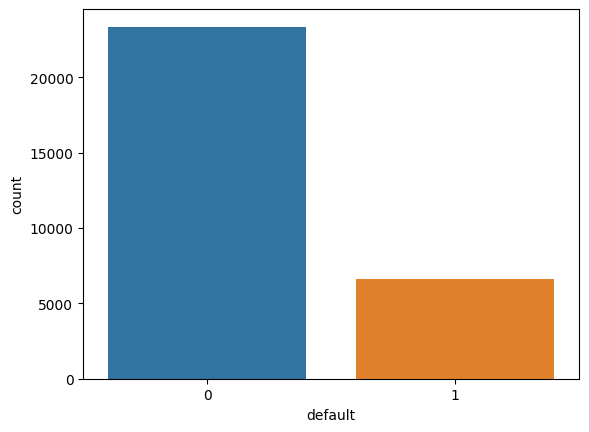

In [9]:
sns.countplot(x=dataframe['default'])

In [10]:
dataframe

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000,1,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,1,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,1,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,1,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,0,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,0,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,0,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,0,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,0,3,1,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


<Axes: >

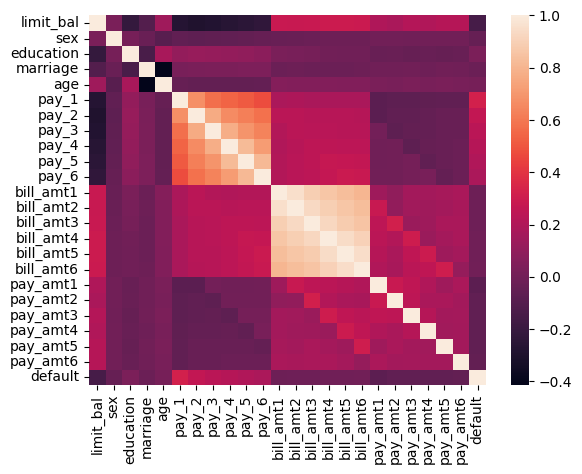

In [11]:
sns.heatmap(dataframe.corr())

<Axes: xlabel='sex', ylabel='count'>

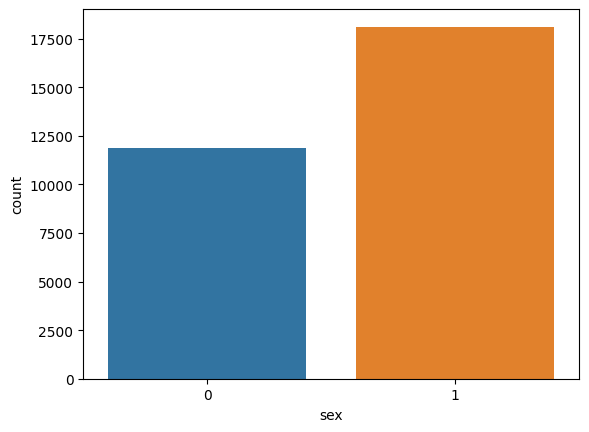

In [12]:
sns.countplot(x=dataframe['sex'])

<Axes: xlabel='marriage', ylabel='count'>

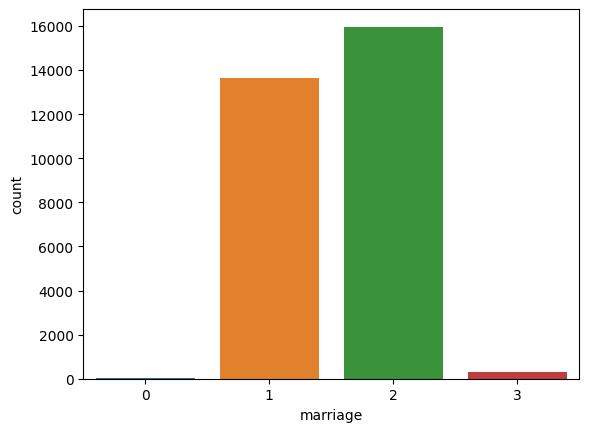

In [13]:
sns.countplot(x=dataframe['marriage'])

<Axes: xlabel='sex', ylabel='default'>

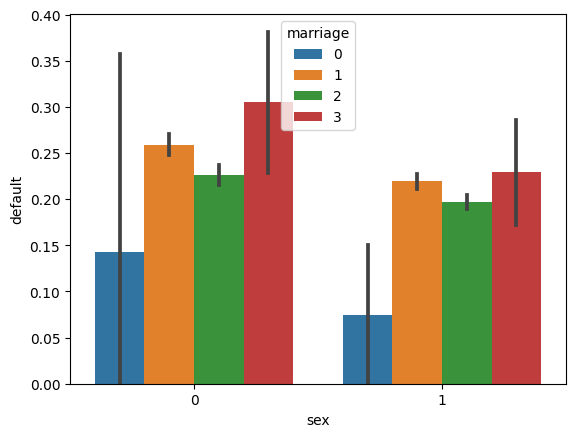

In [14]:
sns.barplot(x='sex', y='default', data=dataframe, hue='marriage')

<Axes: xlabel='age', ylabel='Count'>

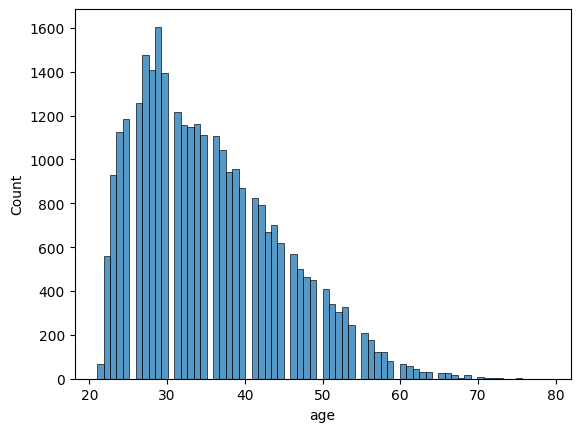

In [15]:
sns.histplot(data=dataframe, x='age')

# Confidence/Prediction intervals for logreg function


# Baseline and comparison with XGBoost
## Logreg


Shapes:
	X_train: 	(27000, 23)
	X_test: 	(3000, 23)

Predicted classes:
	{0: 1593, 1: 1407}

Gini: 
	0.2158153160587557


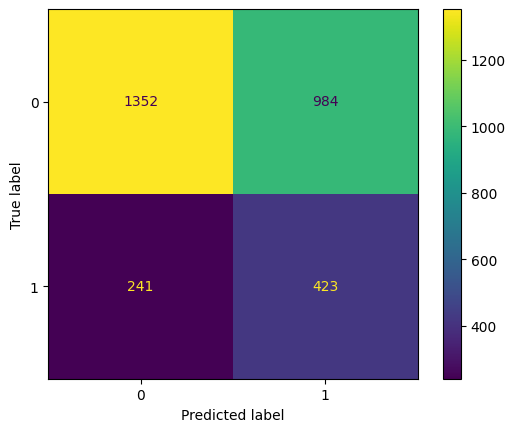

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

THRESHOLD = 0.25

def gini(true, pred_proba):
    return 2*roc_auc_score(true, pred_proba)-1

# train valid test split
y = dataframe['default']
X = dataframe.drop(columns=['default'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
print('''
Shapes:
\tX_train: \t{}
\tX_test: \t{}
'''.format(X_train.shape, X_test.shape))

# baseline logreg model
baseline_logreg = LogisticRegression(max_iter=1000, verbose=False)
baseline_logreg.fit(X_train, y_train)
baseline_logreg_y_pred_proba = baseline_logreg.predict_proba(X_test)
baseline_logreg_y_pred = np.where(baseline_logreg_y_pred_proba[:,1] > THRESHOLD, 1, 0)

baseline_logreg_cm = confusion_matrix(y_test, baseline_logreg_y_pred)
print('Predicted classes:\n\t{}\n'.format(dict(zip(*np.unique(baseline_logreg_y_pred, return_counts=True)))))
ConfusionMatrixDisplay(baseline_logreg_cm).plot()
print('Gini: \n\t{}'.format(gini(y_test, baseline_logreg_y_pred)))

## XGBoost

[19:29:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_iter", "verbose" } are not used.

Predicted classes:
	{0: 2105, 1: 895}

Gini: 
	0.4291910793860372


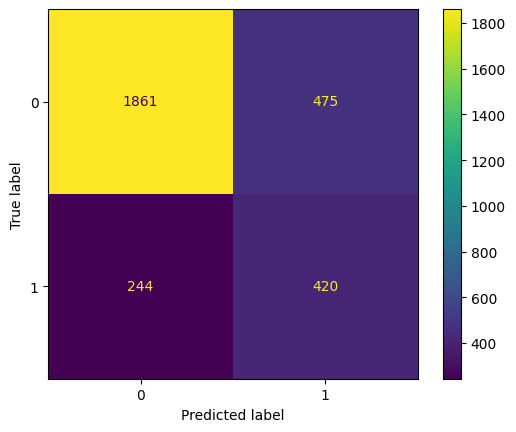

In [152]:
THRESHOLD_XGB = 0.25

# baseline xgboost model
baseline_xgboost = XGBClassifier()
baseline_xgboost.fit(X_train, y_train)
baseline_xgboost_y_pred_proba = baseline_xgboost.predict_proba(X_test)
baseline_xgboost_y_pred = np.where(baseline_xgboost_y_pred_proba[:,1] > THRESHOLD_XGB, 1, 0)

baseline_xgboost_cm = confusion_matrix(y_test, baseline_xgboost_y_pred)
print('Predicted classes:\n\t{}\n'.format(dict(zip(*np.unique(baseline_xgboost_y_pred, return_counts=True)))))
ConfusionMatrixDisplay(baseline_xgboost_cm).plot()
print('Gini: \n\t{}'.format(gini(y_test, baseline_xgboost_y_pred)))

# Main pipeline:
normalization + PCA + logreg CV

In [156]:
dataframe.corrwith())

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
limit_bal,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
sex,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
education,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
marriage,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
age,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
pay_1,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
pay_2,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
pay_3,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
pay_4,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614
pay_5,-0.249411,-0.055064,0.097520,0.035629,-0.053826,0.509426,0.622780,0.686775,0.819835,1.000000,...,0.271915,0.269783,0.262509,-0.006089,-0.003191,0.009062,-0.058299,-0.033337,-0.023027,0.204149
